### 데이터 준비 - twitter

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from smac import HyperparameterOptimizationFacade, Scenario
from ConfigSpace import Configuration, ConfigurationSpace
from ConfigSpace.hyperparameters import UniformFloatHyperparameter, UniformIntegerHyperparameter

In [2]:
### RANDOM WORKLOAD AND SAMPLE
import random
import glob
import os
import sys
import pandas as pd


knob_list = glob.glob("/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_*.cnf")
metrics = pd.read_csv("/home/sein/2023_EDBT/KCC_twitter_dataset/external_metrics/external_results.csv")

# df_1 = df.drop([0, 3], axis = 0)

metrics = metrics.drop(['Unnamed: 0'], axis = 1)
# metrics = pd.DataFrame(metrics)


In [3]:
###전체 샘플에 대한 config num = 200

conf_best_cluster = []
cnt = 0

for xx in range(len(knob_list)):
    path = "/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(xx)
    # knob_list = glob.glob("/home/sein/2023_EDBT/KCC_tpcc_dataset/my_*.cnf")
    a_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    a_all = a_all.set_index("Sample")
    cur_all_df = a_all.T
    
    if cnt == 0:
        concat_all_df = cur_all_df
    else :
        concat_all_df = pd.concat([concat_all_df, cur_all_df], axis=0)
    cnt += 1
concat_all_df = concat_all_df.reset_index()
concat_all_df = concat_all_df.drop(["index"],axis=1)
concat_all_df = concat_all_df.drop(concat_all_df.columns[[0,1]], axis=1)


concat_all_df

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,0,37596,52628590,865990,856318,1,44160666,18380630,4,19,...,277466,706150,340396,500266,38,6204,28678,75343,37285,0
1,1,4945,15395448,412811,823497,0,18944539,17027058,4,27,...,352929,82743,275069,86476,62,11432,15791584,56617,34320,0
2,0,7931,59813952,341095,777123,0,17726392,65906625,2,25,...,241624,595940,386662,142708,41,10048,43343089,79768,33757,0
3,1,13373,60853394,674639,39463,0,26002941,28599726,6,20,...,96888,382249,353552,517077,36,8702,52067907,65251,14319,0
4,1,20819,19850945,603712,740042,1,39419136,22658544,1,6,...,71794,210134,158503,211002,25,4713,3278957,37032,50990,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,59310,28430506,421775,826242,1,1352566,60361339,6,12,...,307047,504687,10111,61073,12,542,2237474,84409,58193,0
196,1,38460,23619454,60256,395272,1,53004944,3740357,5,23,...,500576,197555,114593,150572,18,4169,31980894,5171,80027,1
197,0,24559,23048363,473402,225779,0,64429539,59930358,0,23,...,119159,557676,150172,511835,54,5971,56527511,64639,35982,1
198,0,30682,45247502,264510,806376,0,20579351,51007971,6,24,...,198502,312087,189265,13012,52,8392,48990947,65970,46180,1


### 전체 데이터 (#200 / 139개 knob)에 대한 실험

In [4]:
###XGBRegressor 전체 데이터에 대해서

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np


# def regression_model(X: pd.DataFrame):
#     tps = np.sum(X)
#     latency = np.sum(X)
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

# X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit_transform(X_all)

# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
Y_scaler = MinMaxScaler().fit_transform(Y_all)


estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model = MultiOutputRegressor(estimator = estimator).fit(X_scaler, Y_scaler)



### 전체 config에서 성능이 좋은 config 10개 고르기

In [5]:
### TPS / LATENCY TOP 10

metrics['score'] = metrics['tps'] / metrics['latency']

metric_list_sorting = metrics.sort_values('score', ascending=False)

best_config_perform = metric_list_sorting.head(10)
best_config_perform
# random_metric_list.head(10)

,tps,latency,score
139,7830.031983,550,14.236422
155,7920.117213,558,14.193758
126,7869.536194,555,14.179344
83,7349.121651,582,12.627357
74,7334.782788,590,12.431835
69,7380.264804,594,12.424688
180,7243.303547,583,12.424191
79,6994.513899,580,12.059507
87,7078.647713,597,11.857031
186,7019.134642,594,11.816725


In [6]:
### 성능 좋은 10개 config

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    n_knobs = pd.read_table("/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j]))
    best_config.append(n_knobs)

In [7]:
### best config 10개에 대한 dataframe (knob은 그대로)
cnt = 0

best_config_perform_idx = best_config_perform.index
best_config = []
for j in range(len(best_config_perform_idx)):
    path = "/home/sein/2023_EDBT/KCC_twitter_dataset/knobs/my_{}.cnf".format(best_config_perform_idx[j])
    best_all = pd.read_csv(path, sep="=", names=['Sample', 'value'], header=2)
    best_all = best_all.set_index("Sample")
    cur_best_all = best_all.T
    
    if cnt == 0:
        best_all_df = cur_best_all
    else :
        best_all_df = pd.concat([best_all_df, cur_best_all], axis=0)
    cnt += 1
best_all_df = best_all_df.reset_index()
best_all_df = best_all_df.drop(["index"],axis=1)
best_all_df_ = best_all_df.drop([best_all_df.columns[0],best_all_df.columns[1]], axis=1)
best_all_df = best_all_df_
best_all_df

    

Sample,automatic_sp_privileges,back_log,binlog_cache_size,binlog_group_commit_sync_delay,binlog_group_commit_sync_no_delay_count,binlog_rows_query_log_events,binlog_stmt_cache_size,bulk_insert_buffer_size,default_week_format,div_precision_increment,...,stored_program_cache,sync_binlog,table_definition_cache,table_open_cache,table_open_cache_instances,thread_cache_size,tmp_table_size,transaction_alloc_block_size,transaction_prealloc_size,updatable_views_with_limit
0,1,62584,1539674,944250,574381,1,42675089,50346344,1,4,...,19307,28322,389690,3833,37,4866,54791711,16357,42179,0
1,0,20536,54268864,752489,293510,1,12912030,1329242,1,18,...,395056,823919,267770,238706,14,7156,45254736,126865,30678,0
2,1,48155,21453014,710466,303082,1,3129367,60855972,5,1,...,261099,874783,371028,514859,28,12998,12928821,2472,110140,0
3,1,8399,16055083,801204,372413,1,65373762,26834525,5,6,...,305561,942410,381022,199418,40,12687,64654885,18913,37823,0
4,0,41517,27839073,861937,611627,0,6315291,13395500,3,4,...,285969,416164,487970,101800,6,16369,65044618,94296,121409,1
5,0,35736,15643420,28279,609176,1,7233457,14624045,3,27,...,383043,957444,179646,215135,35,3571,47041272,79333,113716,0
6,1,36190,41421349,86330,764442,0,63778503,55252697,4,14,...,22273,78289,343419,76500,62,14963,27219447,76381,129981,1
7,0,15651,23490671,963633,728258,0,43816068,2172605,4,17,...,143184,114960,10952,264475,47,9643,35860780,48277,21725,0
8,1,58606,31582820,437396,2200,1,5770018,48330654,5,15,...,486023,579353,296695,419276,2,14804,66018124,119323,70036,0
9,0,49017,8355220,718308,246433,1,20460742,14964729,7,15,...,221646,948414,31487,385363,23,3702,10336281,87049,20588,0


### Top-K config 구하기 

In [8]:
###성능 좋은 best_config 10개 뽑기

metrics['score'] = metrics['tps'] / metrics['latency']

metrics_list_sorting = metrics.sort_values('score', ascending=False)

best_config = metrics_list_sorting.head(10)
best_config
# random_metric_list.head(10)

,tps,latency,score
139,7830.031983,550,14.236422
155,7920.117213,558,14.193758
126,7869.536194,555,14.179344
83,7349.121651,582,12.627357
74,7334.782788,590,12.431835
69,7380.264804,594,12.424688
180,7243.303547,583,12.424191
79,6994.513899,580,12.059507
87,7078.647713,597,11.857031
186,7019.134642,594,11.816725


### LASSO, SHAP

In [ ]:
### LASSO

# %pip install lasso
from lasso import LassoPath

lasso_model = LassoPath()

In [ ]:
X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])
scaled_X = MinMaxScaler().fit_transform(X_all)
scaled_y = MinMaxScaler().fit_transform(Y_all)

lasso_model.fit(scaled_X, scaled_y, np.array(concat_all_df.columns))

In [10]:
### SHAP VALUE

###XGBRegressor

from sklearn.preprocessing import MinMaxScaler,StandardScaler
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
# from sklearn.metrics import explained_variance_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, precision_score
import numpy as np

X_all = np.array(concat_all_df)
Y_all = np.array(metrics[['tps', 'latency']])

X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.3, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = MinMaxScaler().fit(y_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
scaled_y_train = Y_scaler.transform(y_train)
scaled_y_test = Y_scaler.transform(y_test)

# xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)

estimator = XGBRegressor(
    objective = 'reg:squarederror',
    random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, scaled_y_train)


pred = my_model_pred.predict(scaled_X_test)

#rmse
print('RMSE : ',mean_squared_error(scaled_y_test, pred, squared=False))
print('R2_SCORE : ', r2_score(scaled_y_test, pred))
# print('PCC : ', precision_score(y_test, pred, average='weighted'))

# rmse r2 pcc




RMSE :  0.26487945178646033
R2_SCORE :  0.2978915840105002


In [11]:
import shap

explainer = shap.KernelExplainer(my_model_pred.predict,scaled_X_test)
shap_values = explainer.shap_values(scaled_X_test)

# shap.summary_plot(shap_values,scaled_X_test,feature_names=shap_x.columns)

# from sklearn.linear_model import LassoLarsIC
# import warnings
# warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
# model = LassoLarsIC(normalize=False)


  0%|          | 0/60 [00:00<?, ?it/s]

[DEBUG][_kernel.py:282] weight_vector = [0.18286679 0.09210079 0.061852   0.04673262 0.0376651  0.03162358
 0.02731127 0.02407979 0.0215689  0.01956249 0.01792302 0.0165588
 0.01540636 0.01442035 0.01356754 0.01282298 0.01216761 0.0115866
 0.01106825 0.0106032  0.01018386 0.00980405 0.00945863 0.00914334
 0.0088546  0.00858939 0.00834511 0.00811957 0.00791085 0.00771731
 0.00753752 0.00737022 0.0072143  0.0070688  0.00693286 0.00680572
 0.0066867  0.0065752  0.00647067 0.00637263 0.00628064 0.00619431
 0.00611328 0.00603723 0.00596587 0.00589893 0.00583617 0.00577738
 0.00572236 0.00567093 0.00562291 0.00557816 0.00553655 0.00549796
 0.00546225 0.00542935 0.00539915 0.00537157 0.00534653 0.00532397
 0.00530383 0.00528605 0.0052706  0.00525742 0.00524649 0.00523778
 0.00523126 0.00522693 0.00522477]
[DEBUG][_kernel.py:283] num_subset_sizes = 69
[DEBUG][_kernel.py:284] num_paired_subset_sizes = 69
[DEBUG][_kernel.py:285] M = 139
[DEBUG][_kernel.py:299] subset_size = 1
[DEBUG][_kernel.py:

In [13]:
shap_x = pd.DataFrame(scaled_X_test) #X_test Dataframe 화
list_int = list(concat_all_df.columns)
list_str = list(map(str, list_int))
shap_x.columns = list_str #add index

# concat_all_df.columns

[DEBUG][pyplot.py:339] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG][pyplot.py:339] Loaded backend module://matplotlib_inline.backend_inline version unknown.


[DEBUG][font_manager.py:1378] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG][font_manager.py:1390] findfont: score(FontEntry(fname='/home/sein/anaconda3/envs/SMAC/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[DEBUG][font_manager.py:1390] findfont: score(FontEntry(fname='/home/sein/anaconda3/envs/SMAC/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
[DEBUG][font_manager.py:1390] findfont: score(FontEntry(fname='/home/sein/anaconda3/envs/SMAC/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[DEBUG

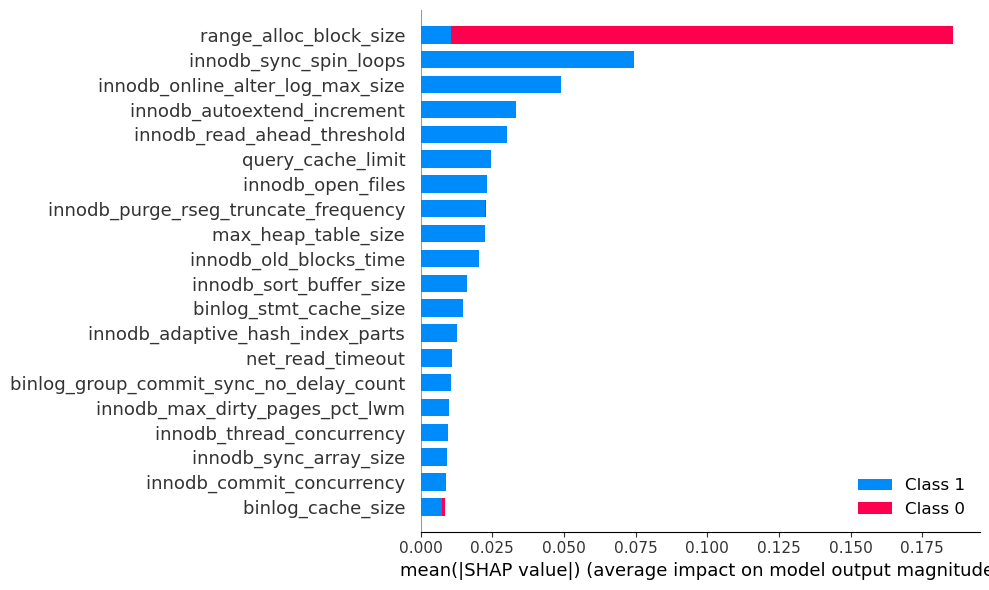

In [14]:
####
import plotly.graph_objs as go

fig = shap.summary_plot(shap_values, scaled_X_test, plot_type="bar" , feature_names=shap_x.columns, plot_size=[10,6] )


In [291]:
# shap_values.sort(reverse=True)
tps_shap_values = pd.DataFrame(shap_values[0])
latency_shap_values = pd.DataFrame(shap_values[1])

tps_shap_values.columns = shap_x.columns
latency_shap_values.columns = shap_x.columns
# latency_shap_values

### tps와 latency에 대한 ranking을 하나로 정리하기 위한 score 계산 (SHAP)

In [ ]:
### tps 순서대로 config 출력

#### About Throuthput

# 데이터프레임을 넘파이로
shap_tps_np = np.array(tps_shap_values)

# array의 값을 절댓값으로 반환
shap_tps_np = np.abs(shap_tps_np)

# axis=0 기준으로 평균값 계산
shap_tps_mean = np.mean(shap_tps_np, 0)

# sorting index 반환
sorted_index_tps = shap_tps_mean.argsort()[::-1]

tps_index = []
for ind in sorted_index_tps:
    print(tps_shap_values.columns[ind])
    tps_index.append(tps_shap_values.columns[ind])

In [293]:
tps_index

['range_alloc_block_size ',
 'expire_logs_days ',
 'innodb_compression_level ',
 'innodb_log_buffer_size ',
 'stored_program_cache ',
 'table_open_cache ',
 'default_week_format ',
 'innodb_rollback_segments ',
 'net_write_timeout ',
 'innodb_io_capacity_max ',
 'automatic_sp_privileges ',
 'innodb_read_io_threads ',
 'innodb_table_locks ',
 'innodb_adaptive_max_sleep_delay ',
 'transaction_prealloc_size ',
 'innodb_deadlock_detect ',
 'back_log ',
 'group_concat_max_len ',
 'binlog_cache_size ',
 'innodb_ft_total_cache_size ',
 'transaction_alloc_block_size ',
 'eq_range_index_dive_limit ',
 'binlog_group_commit_sync_no_delay_count ',
 'query_prealloc_size ',
 'binlog_rows_query_log_events ',
 'innodb_max_purge_lag_delay ',
 'max_digest_length ',
 'key_cache_age_threshold ',
 'innodb_disable_sort_file_cache ',
 'max_points_in_geometry ',
 'innodb_compression_pad_pct_max ',
 'innodb_lru_scan_depth ',
 'innodb_write_io_threads ',
 'max_binlog_stmt_cache_size ',
 'innodb_flush_sync ',
 '

In [ ]:
#### About Latency

# 데이터프레임을 넘파이로
shap_la_np = np.array(latency_shap_values)

# array의 값을 절댓값으로 반환
shap_la_np = np.abs(shap_la_np)

# axis=0 기준으로 평균값 계산
shap_la_mean = np.mean(shap_la_np, 0)

# sorting index 반환
sorted_index_la = shap_la_mean.argsort()[::-1]

latency_index = []
for ind in sorted_index_la:
    print(latency_shap_values.columns[ind])
    latency_index.append(latency_shap_values.columns[ind])

In [295]:
len(latency_index)

139

In [ ]:
all_knob_list = list(concat_all_df.columns)
all_knob_list

In [302]:
import numpy as np
latency_score = dict(zip(latency_index,np.arange(len(latency_index))))
tps_score = dict(zip(tps_index,np.arange(len(tps_index))))
total_score = dict(zip(knob_list, score_list))

knob_list = []
score_list = []
for col in all_knob_list:
    score= latency_score[col]+tps_score[col]
    # print("{} KNOB SCORE : ".format(col), score)
    knob_list.append(col)
    score_list.append(score)
    
    

In [231]:
total_score.values()

dict_values([214, 113, 131, 120, 135, 269, 81, 121, 142, 121, 225, 84, 32, 205, 154, 197, 59, 167, 176, 160, 130, 57, 68, 146, 246, 159, 116, 76, 147, 159, 113, 205, 197, 189, 167, 174, 195, 214, 68, 159, 133, 143, 179, 145, 81, 69, 160, 189, 65, 29, 39, 145, 143, 69, 19, 149, 65, 73, 262, 159, 149, 93, 126, 129, 240, 76, 194, 152, 210, 54, 105, 149, 245, 226, 226, 215, 69, 252, 92, 108, 148, 143, 179, 128, 207, 77, 59, 200, 265, 101, 226, 153, 228, 180, 74, 139, 79, 74, 118, 146, 162, 52, 78, 174, 132, 104, 105, 92, 51, 162, 177, 176, 254, 155, 115, 107, 32, 193, 44, 201, 60, 113, 39, 100, 252, 189, 166, 228, 92, 28, 165, 103, 100, 110, 69, 115, 135, 98, 213])

In [232]:
total_score

{'automatic_sp_privileges ': 214,
 'back_log ': 113,
 'binlog_cache_size ': 131,
 'binlog_group_commit_sync_delay ': 120,
 'binlog_group_commit_sync_no_delay_count ': 135,
 'binlog_rows_query_log_events ': 269,
 'binlog_stmt_cache_size ': 81,
 'bulk_insert_buffer_size ': 121,
 'default_week_format ': 142,
 'div_precision_increment ': 121,
 'end_markers_in_json ': 225,
 'eq_range_index_dive_limit ': 84,
 'expire_logs_days ': 32,
 'explicit_defaults_for_timestamp ': 205,
 'flush_time ': 154,
 'ft_min_word_len ': 197,
 'ft_query_expansion_limit ': 59,
 'general_log ': 167,
 'group_concat_max_len ': 176,
 'innodb_adaptive_hash_index_parts ': 160,
 'innodb_adaptive_max_sleep_delay ': 130,
 'innodb_autoextend_increment ': 57,
 'innodb_buffer_pool_size ': 68,
 'innodb_change_buffer_max_size ': 146,
 'innodb_cmp_per_index_enabled ': 246,
 'innodb_commit_concurrency ': 159,
 'innodb_compression_failure_threshold_pct ': 116,
 'innodb_compression_level ': 76,
 'innodb_compression_pad_pct_max ': 1

In [303]:
print(sorted(total_score.items(), key=lambda x:x[1]))
print(dict(sorted(total_score.items(), key=lambda x:x[1])))
top_rank = sorted(total_score,key=lambda x:total_score[x])

[('range_alloc_block_size ', 0), ('expire_logs_days ', 17), ('innodb_read_io_threads ', 19), ('table_open_cache ', 19), ('stored_program_cache ', 24), ('binlog_group_commit_sync_no_delay_count ', 29), ('innodb_compression_level ', 29), ('innodb_log_buffer_size ', 34), ('back_log ', 37), ('eq_range_index_dive_limit ', 40), ('read_buffer_size ', 45), ('ngram_token_size ', 48), ('innodb_deadlock_detect ', 49), ('innodb_io_capacity_max ', 51), ('automatic_sp_privileges ', 53), ('innodb_max_purge_lag_delay ', 54), ('transaction_alloc_block_size ', 56), ('binlog_cache_size ', 58), ('net_write_timeout ', 58), ('innodb_rollback_segments ', 60), ('innodb_ft_total_cache_size ', 68), ('max_error_count ', 68), ('innodb_max_purge_lag ', 73), ('read_rnd_buffer_size ', 73), ('div_precision_increment ', 75), ('group_concat_max_len ', 82), ('innodb_adaptive_max_sleep_delay ', 83), ('query_prealloc_size ', 83), ('innodb_lru_scan_depth ', 86), ('innodb_buffer_pool_size ', 88), ('ft_query_expansion_limit 

In [304]:
top_10_config = top_rank[:10]

In [305]:
top_10_config

['range_alloc_block_size ',
 'expire_logs_days ',
 'innodb_read_io_threads ',
 'table_open_cache ',
 'stored_program_cache ',
 'binlog_group_commit_sync_no_delay_count ',
 'innodb_compression_level ',
 'innodb_log_buffer_size ',
 'back_log ',
 'eq_range_index_dive_limit ']

### SMAC & BO 

In [351]:
class SMAC(object):
    def __init__(self, iteration, model, config_info_path=None):
        self.iteration = iteration
        self.my_model = model
        self.config_info_path = config_info_path
        
        self._get_config_info()
        self._get_scenario_path_name()
        self._init_configuration()
            
    
    def _get_scenario_path_name(self):
        i = 0
        date_str = datetime.today().strftime("%Y%m%d")
        name = date_str + '-' + '%02d'%i
        while os.path.isdir(os.path.join('smac3_output', name)):
            i += 1
            name = date_str + '-' + '%02d'%i
        self.scenario_name = name
        print("#########################################################")
        print("Scenario data will saved in ", os.path.join('smac3_output', self.scenario_name))
        print("#########################################################\n")
    
    def _get_config_info(self):
        if self.config_info_path is None:
            self.config_info = pd.read_csv('/home/sein/2023_EDBT/config_last_tpcc_top10.csv', index_col=0)
        else:
            self.config_info = pd.read_csv(self.config_info_path, index_col=0)

      
    
    def _get_history(self):
        self.history_configs = self.smac.runhistory.get_configs()
    
    def _init_configuration(self):
        self.cs = ConfigurationSpace()
        
        ## Build Configuriation Generator
        hyps = []
        for name in self.config_info.index:
            knob = self.config_info.loc[name]
            # knob = self.config_info[name]
            
            if knob['type'] == 'boolean' or knob['type'] == 'integer':
                if knob['default'] > knob['max_64mb']:
                    ## If default is larger than max_64mb, then use median of min and max_64mb as default
                    tmp_def = (knob['min'] + knob['max_64mb'].astype(int)) // 2
                else:
                    tmp_def = knob['default']
                hyps.append(UniformIntegerHyperparameter(name=str(name), lower=int(knob['min']), upper=int(knob['max_64mb']), default_value=tmp_def.astype(int)))
            elif knob['type'] == 'float':
                hyps.append(UniformFloatHyperparameter(name=str(name), lower=knob['min'], upper=knob['max_64mb'], default_value=knob['default']))
        self.cs.add_hyperparameters(hyps)
        
        self.scenario = Scenario(self.cs, deterministic=True, n_trials=self.iteration, name=self.scenario_name)
    
    def _target_function(self, config: Configuration, seed: int = 0) -> float:
        X = pd.DataFrame(config.get_dictionary().values(), index=self.config_info.index).T
        ## scaled_X = X.values
        ## scaled_X = Scaler.transform(X)
        ## res = regression_model(scaled_X)
        pred = self.my_model.predict(X)
        for ii in range(len(pred)):
            res = pred[ii][1] / pred[ii][0]
        return res # a smaller result means better
    
    
    def tune(self):
        '''
            After smac.optimize(), the history data are saved in output_dir: 'smac3_output'
        '''
        self.smac = HyperparameterOptimizationFacade(scenario=self.scenario, target_function=self._target_function)
        self.incumbent = self.smac.optimize() #minimize
    
    def plot_history(self):
        self._get_history()
        self.his_inc = []
        inc = np.inf
        ## Get minimum results on each iteration
        for his_cfg in self.history_configs:
            his_res = self.smac.validate(his_cfg)
            if his_res < inc:
                inc = his_res
            self.his_inc.append(inc)
#             res.append(his_res)

        plt.plot(self.his_inc)
        plt.xlabel('Iteration')
        plt.ylabel('result')
        plt.show()

In [357]:
tuner = SMAC(iteration=200, model=my_model)
tuner.tune()

#########################################################
Scenario data will saved in  smac3_output/20230427-36
#########################################################

[INFO][abstract_initial_design.py:82] Reducing the number of initial configurations from 100 to 50 (max_ratio == 0.25).
[INFO][abstract_initial_design.py:134] Using 50 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:306] Using only one seed for deterministic scenario.
[INFO][abstract_intensifier.py:513] Added config 2cd73b as new incumbent because there are no incumbents yet.
[INFO][smbo.py:298] Finished 50 trials.
[INFO][smbo.py:298] Finished 100 trials.
[INFO][smbo.py:298] Finished 150 trials.
[INFO][smbo.py:298] Finished 200 trials.
[INFO][smbo.py:306] Configuration budget is exhausted:
[INFO][smbo.py:307] --- Remaining wallclock time: inf
[INFO][smbo.py:308] --- Remaining cpu time: inf
[INFO][smbo.py:309] --- Remaining trials: 0


In [359]:
new_config = tuner.smac.runhistory.get_configs()
new_config

[Configuration(values={
   'binlog_group_commit_sync_delay': 266878,
   'innodb_adaptive_max_sleep_delay': 620565,
   'innodb_ft_result_cache_limit': 8107224,
   'innodb_io_capacity_max': 21256,
   'innodb_lru_scan_depth': 57803552,
   'max_digest_length': 519586,
   'max_heap_table_size': 64423522,
   'max_prepared_stmt_count': 1045201,
   'max_seeks_for_key': 51817127,
   'transaction_prealloc_size': 93799,
 }),
 Configuration(values={
   'binlog_group_commit_sync_delay': 761236,
   'innodb_adaptive_max_sleep_delay': 268056,
   'innodb_ft_result_cache_limit': 63032976,
   'innodb_io_capacity_max': 95809,
   'innodb_lru_scan_depth': 21466928,
   'max_digest_length': 580661,
   'max_heap_table_size': 12373038,
   'max_prepared_stmt_count': 155942,
   'max_seeks_for_key': 28448221,
   'transaction_prealloc_size': 15810,
 }),
 Configuration(values={
   'binlog_group_commit_sync_delay': 548897,
   'innodb_adaptive_max_sleep_delay': 943590,
   'innodb_ft_result_cache_limit': 30533263,
   '

In [360]:
### 성능 best
best_config_smac = tuner.incumbent
best_config_smac

Configuration(values={
  'binlog_group_commit_sync_delay': 266878,
  'innodb_adaptive_max_sleep_delay': 620565,
  'innodb_ft_result_cache_limit': 8107224,
  'innodb_io_capacity_max': 21256,
  'innodb_lru_scan_depth': 57803552,
  'max_digest_length': 519586,
  'max_heap_table_size': 64423522,
  'max_prepared_stmt_count': 1045201,
  'max_seeks_for_key': 51817127,
  'transaction_prealloc_size': 93799,
})

In [361]:
import configparser as cp

def make_mysql_conf_file(configuration: Configuration, path:str = None):
    '''
        To convert Configuration type to mysql config file
            my_test.cnf
    '''
    if path is None:
        # cnf_file = 'my_test_ycsb_top10_knob{}.cnf'.format(num)
        cnf_file = '[tpcc]CnK_top_10_200iter.cnf'
        
    else:
        cnf_file = path
    
    if os.path.exists(cnf_file) is False:
        f = open(cnf_file, "w")
        f.write("[mysqld]")
        f.close()
    
    config_parser = cp.ConfigParser()
    config_parser.read(cnf_file)
    config_parser.set('mysqld', 'log-error', '/var/log/mysqld.log')
    config_parser.set('mysqld', 'bind-address', '127.0.0.1')  
    config_parser.set('mysqld', 'basedir', '/usr/local/mysql')
    config_parser.set('mysqld', 'datadir', '/usr/local/mysql/data')
    
    for k, v in configuration.items():
        config_parser.set('mysqld', k, str(v))

    config_parser.write(open(cnf_file, 'w'))

In [362]:
# for num in range(len(new_config)):
#     make_mysql_conf_file(new_config[num])

make_mysql_conf_file(best_config_smac)

In [ ]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction


class BO(object):
    def __init__(self, iteration, configs, metrics, top_z_knob=None, reduce_search_space=False, best_configs=None, config_info_path=None):
        self.iteration = iteration
        self.configs = configs
        self.metrics = metrics
        self.config_info_path = config_info_path
        self.reduce_search_space = reduce_search_space
        self.top_z_knob = top_z_knob
        self.best_configs = best_configs
        self.min_max_same_knobs = []
        
        self._get_config_info()
        self._init_pbounds()
    
    def _get_config_info(self):
        if self.config_info_path is None:
            self.config_info = pd.read_csv('data/configs/[230419]flag_MySQL_v5.7.csv', index_col=0)
        else:
            self.config_info = pd.read_csv(self.config_info_path, index_col=0)
        
        if self.top_z_knob is not None:
            self.config_info = self.config_info.loc[self.top_z_knob]
            self.configs = self.configs[self.top_z_knob]
            

#     def _get_history(self):
#         self.history_configs = self.smac.runhistory.get_configs()
    
    def _init_pbounds(self):
        self.pbounds = {}
        
        for name in self.config_info.index:
            knob = self.config_info.loc[name]
            knob_type = knob['type']
            knob_min = knob['min']
            knob_max = knob['max_64mb']
            
            if self.reduce_search_space:
                knob_min = self.best_configs[name].min()
                knob_max = self.best_configs[name].max()
                if knob_min == knob_max:
                    self.min_max_same_knobs.append(name)
                    knob_max += 1
            
            if knob_type == 'boolean' or knob_type == 'integer':
                self.pbounds[name] = (int(knob_min), int(knob_max))
            elif knob_type == 'float':
                self.pbounds[name] = (float(knob_min), float(knob_max))
    
    def train_regression_model(self):
        X_all = np.array(self.configs)
        Y_all = np.array(self.metrics)

        cnt = 0
        while(True):
            X_train, X_test, y_train, y_test = train_test_split(X_all,Y_all,test_size=0.3, shuffle=True)
            self.X_scaler = MinMaxScaler().fit(X_train)
            self.y_scaler = MinMaxScaler().fit(y_train)

            scaled_X_train = self.X_scaler.transform(X_train)
            scaled_X_test = self.X_scaler.transform(X_test)
            scaled_y_train = self.y_scaler.transform(y_train)
            scaled_y_test = self.y_scaler.transform(y_test)

            estimator = XGBRegressor(
                objective = 'reg:squarederror',
                random_state = 2, n_estimators = 100, max_depth = 10, learning_rate = 0.1)

            my_model_pred = MultiOutputRegressor(estimator = estimator).fit(scaled_X_train, scaled_y_train)
            pred = my_model_pred.predict(scaled_X_test)
            accuracy = r2_score(scaled_y_test, pred)

            cnt += 1
            print(cnt, accuracy)
            if accuracy > 0.7 or cnt > 10:
                break

        #rmse
        print('RMSE : ',mean_squared_error(scaled_y_test, pred, squared=False))
        print('R2_SCORE : ', r2_score(scaled_y_test, pred))

        self.model = my_model_pred
    
    def _target_function(self, **kwargs):
        x = np.fromiter(kwargs.values(), dtype=float)        
        scaled_X = self.X_scaler.transform([x])
        
        res = self.model.predict(scaled_X)
        res = res[:,0] / res[:,1]
        
        return res.squeeze()
#         print(y)
        
#         X = pd.DataFrame(config.get_dictionary().values(), index=self.config_info.index).T
#         X = np.array(X)
#         scaled_X = self.X_scaler.transform(X)
        
#         res = self.model.predict(scaled_X)
#         res = res[:,1] / res[:,0]
        
#         return res # a smaller result means better
    
    
    def tune(self):
        self.optimizer = BayesianOptimization(f=self._target_function, pbounds=self.pbounds, verbose=2, random_state=2)
        self.acquisition_function = UtilityFunction(kind="ei", xi=0.01)
        self.optimizer.maximize(n_iter=self.iteration, acquisition_function=self.acquisition_function)
    
    
    def plot_history(self):
        self.y_obs = - np.array([res["target"] for res in self.optimizer.res])
        
        self.his_inc = []
        inc = np.inf
        ## Get minimum results on each iteration
        for res in self.y_obs:
            if res < inc:
                inc = res
            self.his_inc.append(inc)
#             res.append(his_res)

        plt.plot(self.his_inc)
        plt.xlabel('Iteration')
        plt.ylabel('result')
        plt.show()

In [ ]:
tuner1 = BO(iteration=150, 
           configs=configs,
           metrics=metrics[['tps', 'latency']],
           top_z_knob=top_z_knob_names)
tuner1.train_regression_model()
tuner1.tune()
tuner1.plot_history()
make_mysql_conf_file(tuner1.optimizer.max['params'], 'tpcc_bo_top_z_by_shap.cnf')